In [10]:
import tensorflow_text as text
import csv
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np 
import tensorflow as tf 

In [2]:
vocab_size = 20000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = 0.8

In [3]:
articles = []
labels = []

with open('./bbc-text.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    
    for row in reader:
        labels.append(row[0])
        articles.append(row[1])

In [4]:
len(labels), len(articles)

(2225, 2225)

In [7]:
from sklearn.model_selection import train_test_split

train_articles, val_articles, train_labels, val_labels = train_test_split(articles, labels, train_size=training_portion)

In [8]:
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab 

In [9]:
bert_tokenizer_params = dict(lower_case=True)
reserved_tokens = ['[PAD]', '[UNK]', '[START]', '[END]']

bert_vocab_args = dict(
    vocab_size=vocab_size,
    reserved_tokens=reserved_tokens,
    bert_tokenizer_params=bert_tokenizer_params,
    learn_params={}
)

In [11]:
ds = tf.data.Dataset.from_tensor_slices(train_articles)

vocab = bert_vocab.bert_vocab_from_dataset(ds, **bert_vocab_args)

In [12]:
def write_vocab_file(filepath, vocab):
    with open(filepath, 'w') as f:
        for token in vocab:
            print(token, file=f)

In [15]:
write_vocab_file('vocab.txt', vocab)

In [16]:
tokenizer = text.BertTokenizer('vocab.txt', **bert_tokenizer_params)

In [20]:
train_seq_ragged = tokenizer.tokenize(train_articles)
train_sequences = [train_seq.values.numpy().tolist() for train_seq in train_seq_ragged]
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

len(train_sequences), train_padded.shape

(1780, (1780, 200))

In [21]:
val_sequences = tokenizer.tokenize(val_articles)
val_sequences = [val_seq.values.numpy().tolist() for val_seq in val_sequences]
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

len(val_sequences), val_padded.shape

(445, (445, 200))

In [22]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

In [23]:
train_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))-1
val_label_seq = np.array(label_tokenizer.texts_to_sequences(val_labels))-1

#### Training Model

In [28]:
from keras import layers
import keras

https://keras.io/examples/nlp/text_classification_with_transformer/#setup

In [26]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [27]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [34]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(max_length,))
embedding_layer = TokenAndPositionEmbedding(max_length, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [35]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 32)          646400    
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_1 (Transf  (None, 200, 32)          10656     
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_1   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 32)                0   

In [36]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_padded, train_label_seq, batch_size=32, epochs=10, validation_data=(val_padded, val_label_seq))

Epoch 1/10
56/56 [==============================] - 20s 336ms/step - loss: 1.5096 - accuracy: 0.3489 - val_loss: 1.1951 - val_accuracy: 0.5955
Epoch 2/10
56/56 [==============================] - 19s 334ms/step - loss: 0.7570 - accuracy: 0.7528 - val_loss: 0.3862 - val_accuracy: 0.9438
Epoch 3/10
56/56 [==============================] - 18s 330ms/step - loss: 0.1931 - accuracy: 0.9652 - val_loss: 0.1499 - val_accuracy: 0.9618
Epoch 4/10
56/56 [==============================] - 18s 325ms/step - loss: 0.0636 - accuracy: 0.9888 - val_loss: 0.1164 - val_accuracy: 0.9618
Epoch 5/10
56/56 [==============================] - 18s 325ms/step - loss: 0.0272 - accuracy: 0.9978 - val_loss: 0.1111 - val_accuracy: 0.9618
Epoch 6/10
56/56 [==============================] - 18s 325ms/step - loss: 0.0161 - accuracy: 0.9989 - val_loss: 0.1233 - val_accuracy: 0.9551
Epoch 7/10
56/56 [==============================] - 19s 332ms/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.1259 - val_accuracy: 0.9573

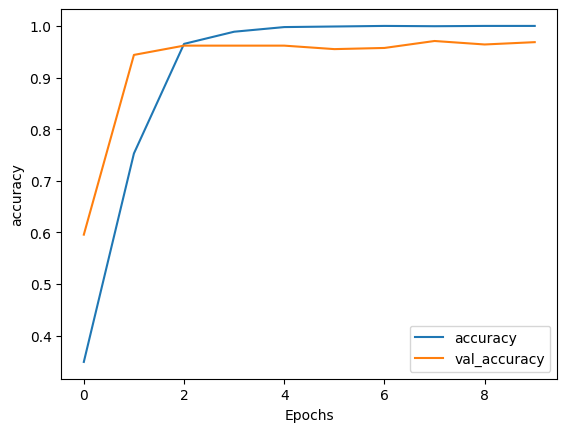

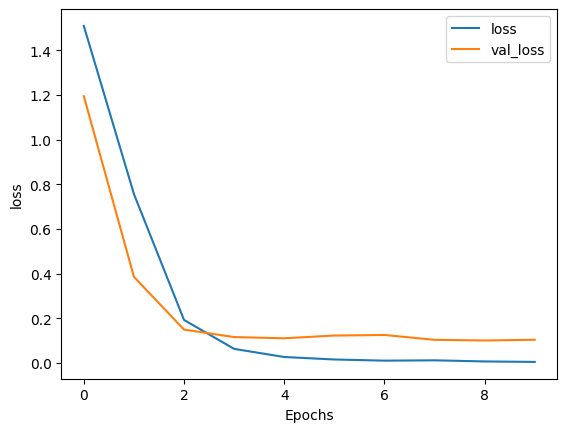

In [37]:
from matplotlib import pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [44]:
txt = ["A WeWork shareholder has taken the company to court over the near-$1.7bn (£1.3bn) leaving package approved for ousted co-founder Adam Neumann."]
seqs = tokenizer.tokenize(txt)
seqs = [seq.values.numpy().tolist() for seq in seqs]
padded = pad_sequences(seqs, maxlen=max_length)

In [53]:
pred = model.predict(padded)

idx = np.argmax(pred)

label = label_tokenizer.word_index
lbl = list(label.keys())

print(label)

print(f"Category: {lbl[idx]}")

1/1 [==============================] - 0s 26ms/step
{'sport': 1, 'business': 2, 'politics': 3, 'tech': 4, 'entertainment': 5}
Category: sport


In [49]:
txt = ["A WeWork shareholder has taken the company to court over the near-$1.7bn (£1.3bn) leaving package approved for ousted co-founder Adam Neumann."]
seqs = tokenizer.tokenize(txt)
seqs = [seq.values.numpy().tolist() for seq in seqs]
padded = pad_sequences(seqs, maxlen=max_length)
pred = model.predict(padded)

labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 48ms/step
[[9.8284388e-01 6.5318932e-04 1.6459011e-02 1.1834951e-05 3.2153741e-05]] sport
